<a href="https://colab.research.google.com/github/ccosmin97/idc-prostate-mri-analysis/blob/main/main_monai_anatomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup -- Restart runtime after execution

In [ ]:
!pip install simpleitk
!pip install -U "monai[all]" pyyaml munch pandas

In [ ]:
%%capture
!sudo apt update
!sudo apt install plastimatch
!sudo apt install subversion
# PyPlastimatch - paython wrapper for Plastimatch (and interactive notebook visualisation)
!svn checkout https://github.com/AIM-Harvard/pyplastimatch/trunk/pyplastimatch pyplastimatch

In [ ]:
!pip install protobuf==3.9.2
!pip install grpcio
!pip install grpcio-tools
!pip install google-cloud-bigquery
!pip install pydicom
!pip install nibabel
!pip install dcm2niix

In [ ]:
%%capture
!sudo apt install subversion

In [ ]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
!git clone https://github.com/pieper/dicomsort.git

Cloning into 'dicomsort'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 130 (delta 0), reused 1 (delta 0), pack-reused 126
Receiving objects: 100% (130/130), 44.12 KiB | 2.10 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
%%capture
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz 
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

In [ ]:
!pip install 'itkwidgets>=1.0a16'

# Monai setup and imports

Download monai bundle from github

In [ ]:
!svn checkout https://github.com/Project-MONAI/model-zoo/trunk/models/prostate_mri_anatomy monai_prostate158/

Imports

In [ ]:
from pyplastimatch import pyplastimatch as pypla
from pyplastimatch.utils import viz as viz_utils
from pyplastimatch.utils import data as data_utils
import nibabel as nib
import numpy as np
import pydicom
import glob
import pandas as pd
import nibabel as nib
import numpy as np
import glob
import os
import json

# CUSTOM FUNCTIONS

Functions designed to retrieve segments information and resampling for evaluation only

In [ ]:
def getLabelID_from_json(input_json, codeMeaning):#, codeValue):
  #json obtained from dcmqi conversion to nifti
  #get labelID corresponding to wanted codeMeaning string value 
  dic_dcm = json.load(open(input_json))
  for index, seg in enumerate(dic_dcm['segmentAttributes']):
    code_mean = seg[0].get('SegmentedPropertyTypeCodeSequence').get('CodeMeaning')
    if code_mean == codeMeaning:
      return seg[0].get('labelID')
    else:
      pass
  return None

In [ ]:
def change_labelID(labelID : int, nii_file : str, output_path_dir : str):
  #change labelID for nifti 
  #for further computation of dice score between reference segment and monai prediction
  nii = nib.load(nii_file)
  header = nii.header 
  img = nii.get_fdata() 
  ind = np.where(img!=0)
  vol = np.zeros((img.shape))
  vol[ind] = labelID
  new_img = nib.Nifti1Image(vol, nii.affine, nii.header)
  output_filename = os.path.join(output_path_dir, nii_file.split('/')[-1])#save in output dir + filename 
  nib.save(new_img, output_filename)

Dataframe pre-processing functions

In [ ]:
def resample_label(row, col_label, col_image, out_folder_root):
  #intended use with dataframe
  #plastimatch resampling of reference segment with reference CT volume
  out_nii = os.path.join(out_folder_root, row[col_label].split('/')[-1])
  resample_args = {"input" : row[col_label],
                   "output" : out_nii,
                   "fixed" : row[col_image],
                   "interpolation" : "nn"}
  pypla.resample(verbose = True, **resample_args)
  return out_nii

In [ ]:
def extract_pz_monai(row, col_label, out_folder_root):
  #this bundle outputs two segments per nifti file 
  #extraction of peripheral zone segment
  out_nii = os.path.join(out_folder_root, row[col_label].split('/')[-1])
  nii_file = nib.load(row[col_label])
  nii_header = nii_file.header
  nii_data = nii_file.get_fdata()
  nii_data[np.where(nii_data != 2)] = 0
  nii_data[np.where(nii_data == 2)] = 1 #get pz label id from monai
  out_img = nib.Nifti1Image(nii_data, nii_file.affine, nii_file.header)
  nib.save(out_img, out_nii)
  return out_nii

In [ ]:
def compute_dice(row, col_pred, col_gt):
  #computation of dice score
  out_plast = !plastimatch dice --dice {row[col_gt]} {row[col_pred]}
  dice_score = [el[1] for el in out_plast.fields() if "DICE" in el[0]][0]#formatting by plastimatch dice output, retrieve of DSC
  return float(dice_score)

In [ ]:
def add_ohif_url(row, datastore='test_datastore', 
                 dataset='prostate-seg', app='fir-idc-prostate-ohif.web.app', 
                 project='idc-sandbox-003', location='us-central1'):
    studyUID = row['StudyInstanceUID']
    return f'https://{app}/viewer/{studyUID}!secondGoogleServer=/projects/{project}/locations/{location}/datasets/{dataset}/dicomStores/{datastore}'

# Setup of IDC data

Colab imports

In [ ]:
#colab 
from google.colab import auth
from scipy import ndimage
auth.authenticate_user()

Setup of GCP project ID

In [ ]:
project_id = "idc-sandbox-003"
# os.environ["GCP_PROJECT_ID"] = project_id

## Data selection, downloading and structuring

We want to select here the collection named qin-prostate repeatibility, and more particularly the two timepoints per patient ID for further analysis.

Query by SeriesInstanceUID and collection and get corresponding segmentation objects

In [ ]:
SeriesInstanceUID_lst = ["1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147"]

In [ ]:
from google.cloud import bigquery
bq_client = bigquery.Client(project_id)
selection_query = f"""
WITH
# studies that have mr volumes
mr_studies AS(
  SELECT
    dicom_all_mr.SOPInstanceUID as SOPInstanceUID, 
    dicom_all_mr.StudyInstanceUID as StudyInstanceUID,
    dicom_all_mr.SeriesInstanceUID as SeriesInstanceUID,
    '' AS segPropertyTypeCodeMeaning, 
    '' AS segPropertyCategoryCodeMeaning,
    (SELECT SeriesInstanceUID FROM UNNEST(dicom_all_mr.ReferencedSeriesSequence)) AS RefSerieUID 
  FROM
    `bigquery-public-data.idc_current.dicom_all` as dicom_all_mr
  WHERE
    collection_id = 'qin_prostate_repeatability'
    AND SeriesInstanceUID IN UNNEST(%s)),

# studies that have segmentations for the whole prostate
seg_studies AS (
SELECT
  dicom_all_seg.SOPInstanceUID as SOPInstanceUID,
  dicom_all_seg.StudyInstanceUID as StudyInstanceUID,
  segmentations.SegmentedPropertyType.CodeMeaning as segPropertyTypeCodeMeaning,
  segmentations.SegmentedPropertyCategory.CodeMeaning as segPropertyCategoryCodeMeaning,
  (SELECT SeriesInstanceUID FROM UNNEST(dicom_all_seg.ReferencedSeriesSequence)) AS RefSerieUID

FROM
  `bigquery-public-data.idc_current.dicom_all` AS dicom_all_seg
JOIN
  `bigquery-public-data.idc_current.segmentations` AS segmentations
ON
  dicom_all_seg.SOPInstanceUID = segmentations.SOPInstanceUID
WHERE
  collection_id = "qin_prostate_repeatability"
AND 
  REGEXP_CONTAINS(segmentations.SegmentedPropertyType.CodeMeaning, r".*Peripheral zone.*")
AND 
  segmentations.SegmentedPropertyCategory.CodeMeaning = 'Anatomical Structure'),

union_mr_seg AS(
  SELECT
    seg_studies.SOPInstanceUID, 
    seg_studies.segPropertyTypeCodeMeaning, 
    seg_studies.segPropertyCategoryCodeMeaning, 
  FROM 
    seg_studies
  JOIN
    mr_studies
  ON
    seg_studies.RefSerieUID = mr_studies.SeriesInstanceUID
  UNION ALL
    SELECT
    mr_studies.SOPInstanceUID, 
    mr_studies.segPropertyTypeCodeMeaning, 
    mr_studies.segPropertyCategoryCodeMeaning, 
  FROM 
    mr_studies)

SELECT 
  DISTINCT(dc_all.SOPInstanceUID),
  dc_all.gcs_url,
  dc_all.SeriesInstanceUID, 
  dc_all.StudyInstanceUID,  
  dc_all.PatientID,
  dc_all.Modality, 
  dc_all.SeriesDescription,
  union_mr_seg.segPropertyTypeCodeMeaning,
  union_mr_seg.segPropertyCategoryCodeMeaning,
  (SELECT SeriesInstanceUID FROM UNNEST(dc_all.ReferencedSeriesSequence)) AS RefSerieUID 
FROM 
  `bigquery-public-data.idc_v10.dicom_all` as dc_all
INNER JOIN
  union_mr_seg
ON 
  dc_all.SOPInstanceUID = union_mr_seg.SOPInstanceUID""" % (SeriesInstanceUID_lst)


selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

Query by collection filling seriesdescription patterns and certain modality

In [ ]:
# from google.cloud import bigquery
# bq_client = bigquery.Client("idc-sandbox-003")
# selection_query = f"""
# WITH
# # studies that have mr volumes
# mr_studies AS(
#   SELECT
#     dicom_all_mr.SOPInstanceUID as SOPInstanceUID, 
#     dicom_all_mr.StudyInstanceUID as StudyInstanceUID,
#     dicom_all_mr.SeriesInstanceUID as SeriesInstanceUID,
#     '' AS segPropertyTypeCodeMeaning, 
#     '' AS segPropertyCategoryCodeMeaning,
#     (SELECT SeriesInstanceUID FROM UNNEST(dicom_all_mr.ReferencedSeriesSequence)) AS RefSerieUID 
#   FROM
#     `bigquery-public-data.idc_current.dicom_all` as dicom_all_mr
#   WHERE
#     Modality = 'MR'
#     AND collection_id = 'qin_prostate_repeatability'
#     AND  REGEXP_CONTAINS(SeriesDescription, r".*T2 Weighted Axial.*")),
# -- ),

 
# # studies that have segmentations for the whole prostate
# seg_studies AS (
# SELECT
#   dicom_all_seg.SOPInstanceUID as SOPInstanceUID,
#   dicom_all_seg.StudyInstanceUID as StudyInstanceUID,
#   segmentations.SegmentedPropertyType.CodeMeaning as segPropertyTypeCodeMeaning,
#   segmentations.SegmentedPropertyCategory.CodeMeaning as segPropertyCategoryCodeMeaning,
#   (SELECT SeriesInstanceUID FROM UNNEST(dicom_all_seg.ReferencedSeriesSequence)) AS RefSerieUID

# FROM
#   `bigquery-public-data.idc_current.dicom_all` AS dicom_all_seg
# JOIN
#   `bigquery-public-data.idc_current.segmentations` AS segmentations
# ON
#   dicom_all_seg.SOPInstanceUID = segmentations.SOPInstanceUID
# WHERE
#   collection_id = "qin_prostate_repeatability"
# AND 
#   REGEXP_CONTAINS(segmentations.SegmentedPropertyType.CodeMeaning, r".*Peripheral zone.*")
# AND 
#   segmentations.SegmentedPropertyCategory.CodeMeaning = 'Anatomical Structure'),

# union_mr_seg AS(
#   SELECT
#     seg_studies.SOPInstanceUID, 
#     seg_studies.segPropertyTypeCodeMeaning, 
#     seg_studies.segPropertyCategoryCodeMeaning, 
#   FROM 
#     seg_studies
#   JOIN
#     mr_studies
#   ON
#     seg_studies.RefSerieUID = mr_studies.SeriesInstanceUID
#   UNION ALL
#     SELECT
#     mr_studies.SOPInstanceUID, 
#     mr_studies.segPropertyTypeCodeMeaning, 
#     mr_studies.segPropertyCategoryCodeMeaning, 
#   FROM 
#     mr_studies)

# SELECT 
#   DISTINCT(dc_all.SOPInstanceUID),
#   dc_all.gcs_url,
#   dc_all.SeriesInstanceUID, 
#   dc_all.StudyInstanceUID,  
#   dc_all.PatientID,
#   dc_all.Modality, 
#   dc_all.SeriesDescription,
#   union_mr_seg.segPropertyTypeCodeMeaning,
#   union_mr_seg.segPropertyCategoryCodeMeaning,
#   (SELECT SeriesInstanceUID FROM UNNEST(dc_all.ReferencedSeriesSequence)) AS RefSerieUID 
# FROM 
#   `bigquery-public-data.idc_v10.dicom_all` as dc_all
# INNER JOIN
#   union_mr_seg
# ON 
#   dc_all.SOPInstanceUID = union_mr_seg.SOPInstanceUID""" 

# selection_result = bq_client.query(selection_query)
# selection_df = selection_result.result().to_dataframe()


In [ ]:
selection_df.head(5)

,SOPInstanceUID,gcs_url,SeriesInstanceUID,StudyInstanceUID,PatientID,Modality,SeriesDescription,segPropertyTypeCodeMeaning,segPropertyCategoryCodeMeaning,RefSerieUID
0,1.3.6.1.4.1.14519.5.2.1.3671.4754.912876150654...,gs://public-datasets-idc/f667774a-05b8-4d1f-b4...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935...,PCAMPMRI-00010,MR,T2 Weighted Axial,,,None
1,1.3.6.1.4.1.14519.5.2.1.3671.4754.223090850152...,gs://public-datasets-idc/f4b5bf23-26d8-4270-87...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935...,PCAMPMRI-00010,MR,T2 Weighted Axial,,,None
2,1.3.6.1.4.1.14519.5.2.1.3671.4754.304718505192...,gs://public-datasets-idc/0823955c-0a10-405d-91...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935...,PCAMPMRI-00010,MR,T2 Weighted Axial,,,None
3,1.3.6.1.4.1.14519.5.2.1.3671.4754.235221964656...,gs://public-datasets-idc/36da713a-bc0c-4da6-98...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935...,PCAMPMRI-00010,MR,T2 Weighted Axial,,,None
4,1.3.6.1.4.1.14519.5.2.1.3671.4754.256365810328...,gs://public-datasets-idc/8ec541c3-7059-44db-81...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935...,PCAMPMRI-00010,MR,T2 Weighted Axial,,,None


In [ ]:
selection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   SOPInstanceUID                  31 non-null     object
 1   gcs_url                         31 non-null     object
 2   SeriesInstanceUID               31 non-null     object
 3   StudyInstanceUID                31 non-null     object
 4   PatientID                       31 non-null     object
 5   Modality                        31 non-null     object
 6   SeriesDescription               31 non-null     object
 7   segPropertyTypeCodeMeaning      31 non-null     object
 8   segPropertyCategoryCodeMeaning  31 non-null     object
 9   RefSerieUID                     1 non-null      object
dtypes: object(10)
memory usage: 2.5+ KB


In [ ]:
print(f"Number of Studies selected :{len(selection_df.StudyInstanceUID.unique())}")
print(f"Number of Series selected : {len(selection_df.SeriesInstanceUID.unique())}")
print(f"Unique modalities selected : {selection_df.Modality.unique()}")
print(f"Unique SeriesDescription selected : {selection_df.SeriesDescription.unique()}")

Number of Studies selected :1
Number of Series selected : 2
Unique modalities selected : ['MR' 'SEG']
Unique SeriesDescription selected : ['T2 Weighted Axial' 'T2 Weighted Axial Segmentations']


In [ ]:
selection_df.PatientID.unique()

array(['PCAMPMRI-00010'], dtype=object)

### Download IDC Data from gcs urls

Create output folder for downloads

In [ ]:
!mkdir -p IDC_Downloads

Creation of manifest and saving of the list of GCS URLs into a file


In [ ]:
selection_manifest = os.path.join("IDC_Downloads", "idc_manifest.txt")
selection_df["gcs_url"].to_csv(selection_manifest, header=False, index=False)

In [ ]:
# confirm the resulting manifest has as many lines as the number of rows in the
# dataframe we initialized earlier
!cat {selection_manifest} |wc

     31      31    2046


let's make sure the download folder is clean, in case you ran this cell earlier for a different dataset

In [ ]:
!rm -rf {os.environ["IDC_Downloads"]+"/*.dcm"}

In [ ]:
# download is this simple!

!cat {selection_manifest} | gsutil -m cp -I IDC_Downloads

To facilitate preparation of the data, we will sort the downloaded files into the PatientID/StudyInstanceUID/SeriesInstanceUID hierarchy.

In [ ]:
!mkdir -p IDC_Downloads_Sorted

In [ ]:
!python dicomsort/dicomsort.py -k -u IDC_Downloads IDC_Downloads_Sorted/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm

100% 32/32 [00:00<00:00, 181.79it/s]
Files sorted


Move the sorted data into the right place

In [ ]:
#final sorted IDC DCM data output folder
!mkdir -p dcm_data

In [ ]:
!rm -rf dcm_data/* && mv IDC_Downloads_Sorted/* dcm_data/

Conversion of IDC DCM data to NIFTI format

In [ ]:
!rm -rf nifti_idc
!mkdir -p nifti_idc

In [ ]:
for study in sorted(glob.glob(os.path.join("dcm_data", "*", "*"))): #studies in IDC DCM data folder : patID/study/serie/...
  !mkdir -p nifti_idc/{study.split('/')[-1]}#creation of output folder
  series_lst = sorted(glob.glob(os.path.join(study, "*")))#series list in study folder
  for serie in series_lst:#iterate list of series for each study
    if pydicom.dcmread(glob.glob(os.path.join(serie,"*"))[0]).Modality == "SEG": #seg dcm file based on modality tag / 
      print(f"seg dcm {serie}")
      #conversion to nifti using platimatch
      path_file_dcm_seg = glob.glob(serie+"/*.dcm")[0]#absolute path of dcm seg file
      !mkdir -p nifti_idc/{study.split('/')[-1]} #creation of output path
      !segimage2itkimage --inputDICOM $path_file_dcm_seg --outputDirectory nifti_idc/{study.split('/')[-1]} --outputType nii #conversion to nifti using plastimatch wrapper tool
    elif pydicom.dcmread(glob.glob(os.path.join(serie,"*"))[0]).Modality == "MR": #T2 volume
      print("image serie")
      print(serie)
      !mkdir -p nifti_idc/{study.split('/')[-1]} #absolute path of dcm CT file
      !dcm2niix -z y -m y -o  nifti_idc/{study.split('/')[-1]}/ $serie #conversion of T2 volume to nifti using dcm2niix tool
    print()

seg dcm dcm_data/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/1.2.276.0.7230010.3.1.3.1426846371.7872.1513205171.131
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
W: CodeValue (0008,0100) empty in CodeSequenceMacro (type 1C)
Row direction: 0.999066 0.0430724 -0.00344915
Col direction: -0.0427834 0.997223 0.0609655
Z direction: 0.0060655 -0.060761 0.998134
Total frames: 120
Total frames with unique IPP: 30
Total overlapping frames: 30
Origin: [-86.4606, -39.8495, -148.412]

image serie
dcm_data/PCAMPMRI-00010/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147
Chris Rorden's dcm2niiX version v1.0.20220505  GCC9.4.0 x86-64 (64-bit Linux)
Found 30 DICOM file(s)
Convert 30 DICOM as nifti_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-

### Preprocessing : Take whole prostate segment -- change labelID to 1 and resample to reference T2 image

Creation of output folders

In [ ]:
!rm -rf test_data_idc
!mkdir test_data_idc

Init of output dataframe for monai bundle inference

In [ ]:
test_df = pd.DataFrame(columns=["t2", "t2_label"])

Preprocessing happens below



1.   Get peripheral zone ground-truth IDC segment from nifti idc data -- individuals nifti segments with metadata.json, cf. dcmqi 
2.   Resample of segmentation nifti files to reference T2 volume
3.   ensure labelID = 1 for nifti ground-truth segments of peripheral zone  



In [ ]:
for json_meta in sorted(glob.glob(os.path.join("/content/nifti_idc", "*", "*meta.json"))):
  print(json_meta)# dcmqi metadata.json
  codeMeaningProstate = "Prostate"
  codeMeaningPZ = "Peripheral zone of the prostate"
  labelIDPz = getLabelID_from_json(json_meta, codeMeaning=codeMeaningPZ)#labelID corresponding to peripheral zone, could be 1.nii.gz or 2.nii.gz,..
  studyUID = json_meta.split('/')[-2]#retrieve studyUID from absolute path
  nii_pz = glob.glob(f"{'/'.join(json_meta.split('/')[:-1])}/{labelIDPz}.nii.gz")[0]#absolute path of PZ IDC GT segment
  nii_lst = glob.glob(os.path.join('/'.join(json_meta.split('/')[:-1]), "*.nii.gz"))#absolute path of nii files corresping to study
  t2_image = [nii_file for nii_file in nii_lst if len(nii_file.split('/')[-1]) > 20][0]#quick hack to retrieve t2 image, better solution use metadata stored in dfs
  print(t2_image)
  print()
  #same for pz
  out_pz_nii = f"{t2_image.split('/')[-1][:-7]}_pz.nii.gz"#name of pz nifti file
  out_pz_nii_path = os.path.join("test_data_idc", out_pz_nii)#absolute path
  resample_args = {"input" : nii_pz,
                   "output" : out_pz_nii_path,
                   "fixed" : t2_image,
                   "interpolation" : "nn"}
  #resample to t2 mod based on study -- not uniform across studies
  pypla.resample(verbose = True, **resample_args)#resampling of pz idc segment to T2 ref volume
  out_t2_image_path = os.path.join('test_data_idc', t2_image.split('/')[-1])
  !cp $t2_image $out_t2_image_path #copy CT volume to test_data for monai bundle inference
  test_df = test_df.append({"t2" : out_t2_image_path.split('/')[-1], 
                            "t2_label" : out_pz_nii}, ignore_index=True)#append t2, t2_label to dataframe used further for monai bundle inference
  change_labelID(1, out_pz_nii_path, '/'.join(out_pz_nii_path.split('/')[:-1]))#change labelID to 1

/content/nifti_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/meta.json
/content/nifti_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6.nii.gz


Running 'plastimatch resample' with the specified arguments:
  --input /content/nifti_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/2.nii.gz
  --output test_data_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6_pz.nii.gz
  --fixed /content/nifti_idc/1.3.6.1.4.1.14519.5.2.1.3671.4754.318227959935022390930294557376/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6.nii.gz
  --interpolation nn
... Done.


<ipython-input-30-fe7569fcc23f>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append({"t2" : out_t2_image_path.split('/')[-1],


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   t2        1 non-null      object
 1   t2_label  1 non-null      object
dtypes: object(2)
memory usage: 144.0+ bytes


In [ ]:
test_df.head()

,t2,t2_label
0,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...


### Upload to google buckets -- monai prepared data

Used for preparation of IDC data -- not useful for inference 

upload idc dcm data to bucket

In [ ]:
# !gsutil cp -r /content/test_data_idc gs://prostate-seg-monai/

upload monai metadata for t2 and t2 label paths

In [ ]:
# test_df.to_csv("test.csv")
# !gsutil cp  /content/test.csv gs://prostate-seg-monai/

copy idc prepared data to local workspace ready for monai bundle inference

In [ ]:
# !gsutil cp -r gs://prostate-seg-monai/test_data_idc/* {os.environ["monai_workspace_dataset"]}/
# !gsutil cp -r gs://prostate-seg-monai/test.csv {os.environ["monai_workspace_dataset"]}/

# Run Monai inference

## Setup of working directory for evalutation

In [ ]:
os.environ["monai_workspace"] = "monai_workspace"
os.environ["monai_workspace_eval"] = os.path.join(os.environ["monai_workspace"], "eval/")
os.environ["monai_workspace_dataset"] = os.path.join(os.environ["monai_workspace"], "dataset/")
os.environ["monai_workspace_model_dir"] = os.path.join(os.environ["monai_workspace"], "models")
os.environ["monai_workspace_model_path"] = os.path.join(os.environ["monai_workspace"], "models", "anatomy.pt")

In [ ]:
!mkdir -p {os.environ["monai_workspace"]}
!mkdir -p {os.environ["monai_workspace_eval"]}
!mkdir -p {os.environ["monai_workspace_dataset"]}
!mkdir -p {os.environ["monai_workspace_model_dir"]}

Copy/Downloads



*   Copy of inference.json from monai bundle to custom workspace
*   Download of anatomy.pt weights from zenodo



In [ ]:
!cp /content/monai_prostate158/configs/inference.json {os.environ["monai_workspace"]}/inference.json
!wget https://zenodo.org/record/7040585/files/anatomy.pt?download=1 -O {os.environ["monai_workspace_model_dir"]}/anatomy.pt

--2023-01-17 21:31:30--  https://zenodo.org/record/7040585/files/anatomy.pt?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152810901 (146M) [application/octet-stream]
Saving to: ‘monai_workspace/models/anatomy.pt’

monai_workspace/mod 100%[===================>] 145.73M  28.5MB/s    in 5.8s    

2023-01-17 21:31:38 (25.2 MB/s) - ‘monai_workspace/models/anatomy.pt’ saved [152810901/152810901]



Copy idc data and metadata csv to monai workspace 

In [ ]:
!cp -r test_data_idc/* {os.environ["monai_workspace_dataset"]}/
test_df.to_csv(os.path.join(os.environ["monai_workspace_dataset"], "test.csv"))

Setup of inference.json parameters

In [ ]:
inference_json = json.load(open(os.environ["monai_workspace"]+"/inference.json"))
#setup variables
inference_json["bundle_root"] = os.environ["monai_workspace"]
inference_json["output_dir"] = os.environ["monai_workspace_eval"]
inference_json["dataset_dir"] = os.environ["monai_workspace_dataset"]
inference_json["handlers"][0]["load_path"] = os.environ["monai_workspace_model_path"]
inference_json["datalist"] = "$list(@dataset_dir + pd.read_csv(@dataset_dir + 'test.csv').t2)"

Overriding of inference.json to local workspace

In [ ]:
with open('/content/monai_workspace/inference.json', 'w') as fp:
    json.dump(inference_json, fp)

## Inference

Initialize monai configParser and import inference.json

In [ ]:
from monai.bundle import ConfigParser, run
config = ConfigParser()
config.read_config("/content/monai_workspace/inference.json")

Inference using monai bundle -- metadata.json provided from monai bundle, no change needed

In [ ]:
!python -m monai.bundle run evaluating --meta_file /content/monai_prostate158/configs/metadata.json --config_file /content/monai_workspace/inference.json

2023-01-17 21:32:16,393 - INFO - --- input summary of monai.bundle.scripts.run ---
2023-01-17 21:32:16,393 - INFO - > runner_id: 'evaluating'
2023-01-17 21:32:16,393 - INFO - > meta_file: '/content/monai_prostate158/configs/metadata.json'
2023-01-17 21:32:16,393 - INFO - > config_file: '/content/monai_workspace/inference.json'
2023-01-17 21:32:16,393 - INFO - ---


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
2023-01-17 21:32:22,029 - Engine run resuming from iteration 0, epoch 0 until 1 epochs
2023-01-17 21:32:22,146 - Restored all variables from monai_workspace/models/anatomy.pt
2023-01-17 21:32:45,003 INFO image_writer.py:194 - writing: monai_workspace/eval/1.3.6.1.4.1.14519.5.2.1.367

# Evaluation of monai data

Setup folders for evaluation

In [ ]:
!mkdir -p data_resampled
!mkdir -p data_resampled/images
!mkdir -p data_resampled/ground_truth
!mkdir -p data_resampled/monai_preds
!mkdir -p data_resampled/monai_preds_pz

## Build up dataframe with added colums : 


1.   t2
2.   t2_label_pz
3.   t2_label_prostate
4.   monai_pz


In [ ]:
eval_df = pd.read_csv('/content/monai_workspace/dataset/test.csv', index_col=0)

In [ ]:
eval_df.head()

,t2,t2_label
0,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...,1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314...


Add additional columns to dataframe for evaluation 



1.   monai_pred : absolute paths of monai predictions
2.   t2 : paths of t2 volumes in local workspace
3.   t2_label : paths of t2 peripheral zone absolute paths in local workspace
4.   monai_pred_resampled : monai preds resampled to T2 volume
5.   monai_pred_resampled_pz : extraction of PZ segment from resampled monai prediction
6.   dice_score_pz : dice_score between t2_label and monai_preds_resampled_pz



In [ ]:
eval_df["monai_pred"]= eval_df.t2.apply(lambda x : glob.glob(f"/content/monai_workspace/eval/**/{x[:-7]}_trans.nii.gz", recursive=True)[0])
eval_df["t2"]= eval_df.t2.apply(lambda x : "/content/monai_workspace/dataset/"+x)
eval_df["t2_label"]= eval_df.t2_label.apply(lambda x : "/content/monai_workspace/dataset/"+x)

Resampling of monai preds in reference of T2 volume 

In [ ]:
eval_df["monai_pred_resampled"] = eval_df.apply(resample_label, axis = 1,
                    args = ["monai_pred", "t2", "data_resampled/monai_preds/"])


Running 'plastimatch resample' with the specified arguments:
  --input /content/monai_workspace/eval/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6_trans.nii.gz
  --output data_resampled/monai_preds/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6_trans.nii.gz
  --fixed /content/monai_workspace/dataset/1.3.6.1.4.1.14519.5.2.1.3671.4754.105976129314091491952445656147_Prostate_With_e-coil_C-_19950709150441_6.nii.gz
  --interpolation nn
... Done.


In [ ]:
eval_df["monai_pred_resampled_pz"] = eval_df.apply(extract_pz_monai, axis = 1,
                    args = ["monai_pred_resampled", "data_resampled/monai_preds_pz"])

In [ ]:
eval_df["dice_score_pz"] = eval_df.apply(compute_dice, axis=1,
                                         args= ["monai_pred_resampled_pz", "t2_label"])

In [ ]:
eval_df[["monai_pred_resampled", "dice_score_pz"]].head(60)

,monai_pred_resampled,dice_score_pz
0,data_resampled/monai_preds/1.3.6.1.4.1.14519.5...,0.573206


Average of dice_score

In [ ]:
np.mean(eval_df["dice_score_pz"].values)

0.573206

Boxplot of dice_score

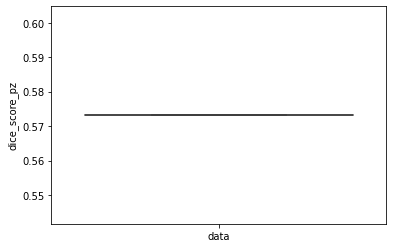

In [ ]:
import seaborn as sns
sns.boxplot(x=["data"] * len(eval_df), y="dice_score_pz", data=eval_df)

In [ ]:
eval_df

,t2,t2_label,monai_pred,monai_pred_resampled,monai_pred_resampled_pz,dice_score_pz
0,/content/monai_workspace/dataset/1.3.6.1.4.1.1...,/content/monai_workspace/dataset/1.3.6.1.4.1.1...,/content/monai_workspace/eval/1.3.6.1.4.1.1451...,data_resampled/monai_preds/1.3.6.1.4.1.14519.5...,data_resampled/monai_preds_pz/1.3.6.1.4.1.1451...,0.573206


ITK Widget visualization

In [ ]:
import SimpleITK as sitk
import numpy as np
import itk

t2_label = sitk.GetArrayFromImage(sitk.ReadImage(list(eval_df.monai_pred_resampled.values)[0]))
t2 = sitk.GetArrayFromImage(sitk.ReadImage(list(eval_df.t2.values)[0]))

In [ ]:
view?

In [ ]:
from itkwidgets import view
# view(image=t2, label_image=t2_label)
image = itk.imread(list(eval_df.t2.values)[0])
label = itk.imread(list(eval_df.t2_label.values)[0])
view(image, label_image=label)
# view(image=t2[:, :, :] * 255, gradient_opacity=0.6)

# Upload of monai preds to dicom store and ohif integration

Creation of output folder

In [ ]:
!mkdir -p data_resampled/dcm_monai_preds

### Conversion to dcm of monai predictions

In [ ]:
# this will usually take between one and five minutes (but can sometimes take up to eight)
seg_whole_prostate_json = "https://www.dropbox.com/s/y11eg3ek4gu8p4i/seg-example_multiple_segments_single_input_file.json?dl=0"
seg_dcm_metadata_json_file = "pred_metadata.json"
!wget -O $seg_dcm_metadata_json_file $seg_whole_prostate_json

--2023-01-17 21:33:29--  https://www.dropbox.com/s/y11eg3ek4gu8p4i/seg-example_multiple_segments_single_input_file.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/y11eg3ek4gu8p4i/seg-example_multiple_segments_single_input_file.json [following]
--2023-01-17 21:33:29--  https://www.dropbox.com/s/raw/y11eg3ek4gu8p4i/seg-example_multiple_segments_single_input_file.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc55e3c05f0f3567e78e5a6366f5.dl.dropboxusercontent.com/cd/0/inline/B0x30EWEBwlsoE4AvKfDRELvqc2CQxW43bkTcpGM88gBIaRwzmxGOd4ye1uPyl4MYsKglzA6eFQYUzl760za_J3Jy0ynh_X9Xi0KKu5-RD622q1ShNXEiGWyaJvo3tB_jVoSRH_iya0PdmtQ7HGj3ySdSAcBRFff-l2ELNaiZlO6QA/file# [following]
--2023-01-17 21:33:29--  https://uc55e3c05f0f3567e78e5a

Conversion of monai preds to DCM

In [ ]:
for nii_seg_pred in glob.glob(os.path.join("/content/data_resampled/monai_preds", '*.nii.gz')):
  serieUID_pred = nii_seg_pred.split('/')[-1].split('_')[0]
  t2_dcm_folder = glob.glob(os.path.join("/content/dcm_data", "**", "**", serieUID_pred))[0]
  print(t2_dcm_folder)
  print()
  # #find seg dcm file
  # # find nii seg folder == preds resampled
  assert os.path.exists(t2_dcm_folder)
  print('\nConverting...')
  print(f'pred monai procssed : {nii_seg_pred}')
  print(f't2_dcm_folder : {t2_dcm_folder}')
  output_path = os.path.join("data_resampled/dcm_monai_preds", '_'.join([nii_seg_pred.split('/')[-1][:-7]])+'.dcm')
  # #find gt seg dcm file == orginal idc dcm files
  # #convert nii pred to dcm
  !itkimage2segimage --inputImageList $nii_seg_pred \
  --inputDICOMDirectory  $t2_dcm_folder \
  --inputMetadata  $seg_dcm_metadata_json_file \
  --outputDICOM $output_path 
  print("Done!")

## EXPORT TO OHIF 

OHIF viewer already deployed

https://tinyurl.com/idc-ohif-gcp

### Upload to GCP Bucket

#### User input 

Set these values. 

In [ ]:
project_name = 'idc-sandbox-003'
location_id = 'us-central1'
my_dataset = 'prostate-seg'
my_datastore = 'pz_tz_monai_2ServersIDC'

In [ ]:
!gsutil -m cp /content/data_resampled/dcm_monai_preds/* gs://prostate-seg-use-case/monai-prostate158/preds/

In [ ]:
!gsutil -m cp -r /content/dcm_data/* gs://prostate-seg-use-case/monai-prostate158/input_data/

## Upload to dicom store

In [ ]:
!gcloud healthcare dicom-stores import gcs pz_tz_monai_prostate158_2ServersIDC \
                                            --dataset=prostate-seg \
                                            --location=us-central1 \
                                            --project=idc-sandbox-003 \
                                            --gcs-uri=gs://prostate-seg-use-case/monai-prostate158/preds/**.dcm

Request issued for: [pz_tz_monai_prostate158_2ServersIDC]
name: projects/idc-sandbox-003/locations/us-central1/datasets/prostate-seg/dicomStores/pz_tz_monai_prostate158_2ServersIDC


## Write to Big Query table

In [ ]:
eval_df["ohif_url"] = eval_df.apply(add_ohif_url, args = ["pz_tz_monai_prostate158_2ServersIDC", "prostate-seg", "fir-idc-prostate-ohif.web.app", "idc-sandbox-003", "us-central1"], axis=1)
eval_df["cloud_storage_path"] = eval_df.apply(lambda x : "/prostate-seg-use-case/monai-prostate158/preds/", axis=1)

In [ ]:
# Construct a BigQuery client object.
bq_client = bigquery.Client("idc-sandbox-003")
table_id = "idc-sandbox-003.prostate_mri_anatomy_monai.pz_segment"#prostatex.whole_prostate_dcm_no_gt_final"

job = bq_client.load_table_from_dataframe(
    eval_df, table_id
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = bq_client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/_pandas_helpers.py:275: UserWarning: Unable to determine type of column 'ReferencedSeriesInstanceUID'.
  warnings.warn(u"Unable to determine type of column '{}'.".format(column))


Loaded 281 rows and 15 columns to idc-sandbox-003.prostatex.whole_prostate_dcm_no_gt_final
